In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Plot / Graph stuffs
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))

Wine_Reviews.ipynb
avas_allboundaries.geojson
country-codes.csv
geonames-all-cities-with-a-population-1000.csv
global-polygons.csv
ne_10m_admin_0_map_subunits
ne_10m_admin_0_map_units
ne_10m_admin_1_states_provinces
ne_10m_admin_2_counties
requirements.txt
wine
wine-review-sample.csv
wine_review_data.joblib
winemag-data-130k-v2.csv
winemag-data-130k-v2.json
winemag-data_first150k.csv
wineries



## Initial Overview of Data
I plan to parse the data and view it in its most raw form.

In [3]:
init_data = pd.read_csv("./data/winemag-data-130k-v2.csv")
print("Length of dataframe before duplicates are removed:", len(init_data))
init_data.head()

Length of dataframe before duplicates are removed: 129971


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Drop Duplicates and NaNs (nulls)
I need to drop the duplicates and null values from the data.

In [4]:
parsed_data = init_data[init_data.duplicated('description', keep=False)]
print("Length of dataframe after duplicates are removed:", len(parsed_data))

parsed_data.dropna(subset=['description', 'points'])
print("Length of dataframe after NaNs are removed:", len(parsed_data))

parsed_data.head()

Length of dataframe after duplicates are removed: 20026
Length of dataframe after NaNs are removed: 20026


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
11,11,France,"This is a dry wine, very spicy, with a tight, ...",NaN,87,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer
12,12,US,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini
13,13,Italy,This is dominated by oak and oak-driven aromas...,Rosso,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Masseria Setteporte 2012 Rosso (Etna),Nerello Mascalese,Masseria Setteporte


## First Data Look

Let's take a look at our data "description" vs "points":

In [5]:
dp = parsed_data[['description','points']]
dp.info()
dp.head()

<class 'pandas.core.frame.DataFrame'>
Index: 20026 entries, 9 to 129913
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  20026 non-null  object
 1   points       20026 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 469.4+ KB


,description,points
9,This has great depth of flavor with its fresh ...,87
10,"Soft, supple plum envelopes an oaky structure ...",87
11,"This is a dry wine, very spicy, with a tight, ...",87
12,"Slightly reduced, this wine offers a chalky, t...",87
13,This is dominated by oak and oak-driven aromas...,87


How many wines per points?
That's basically the distribution of our data model

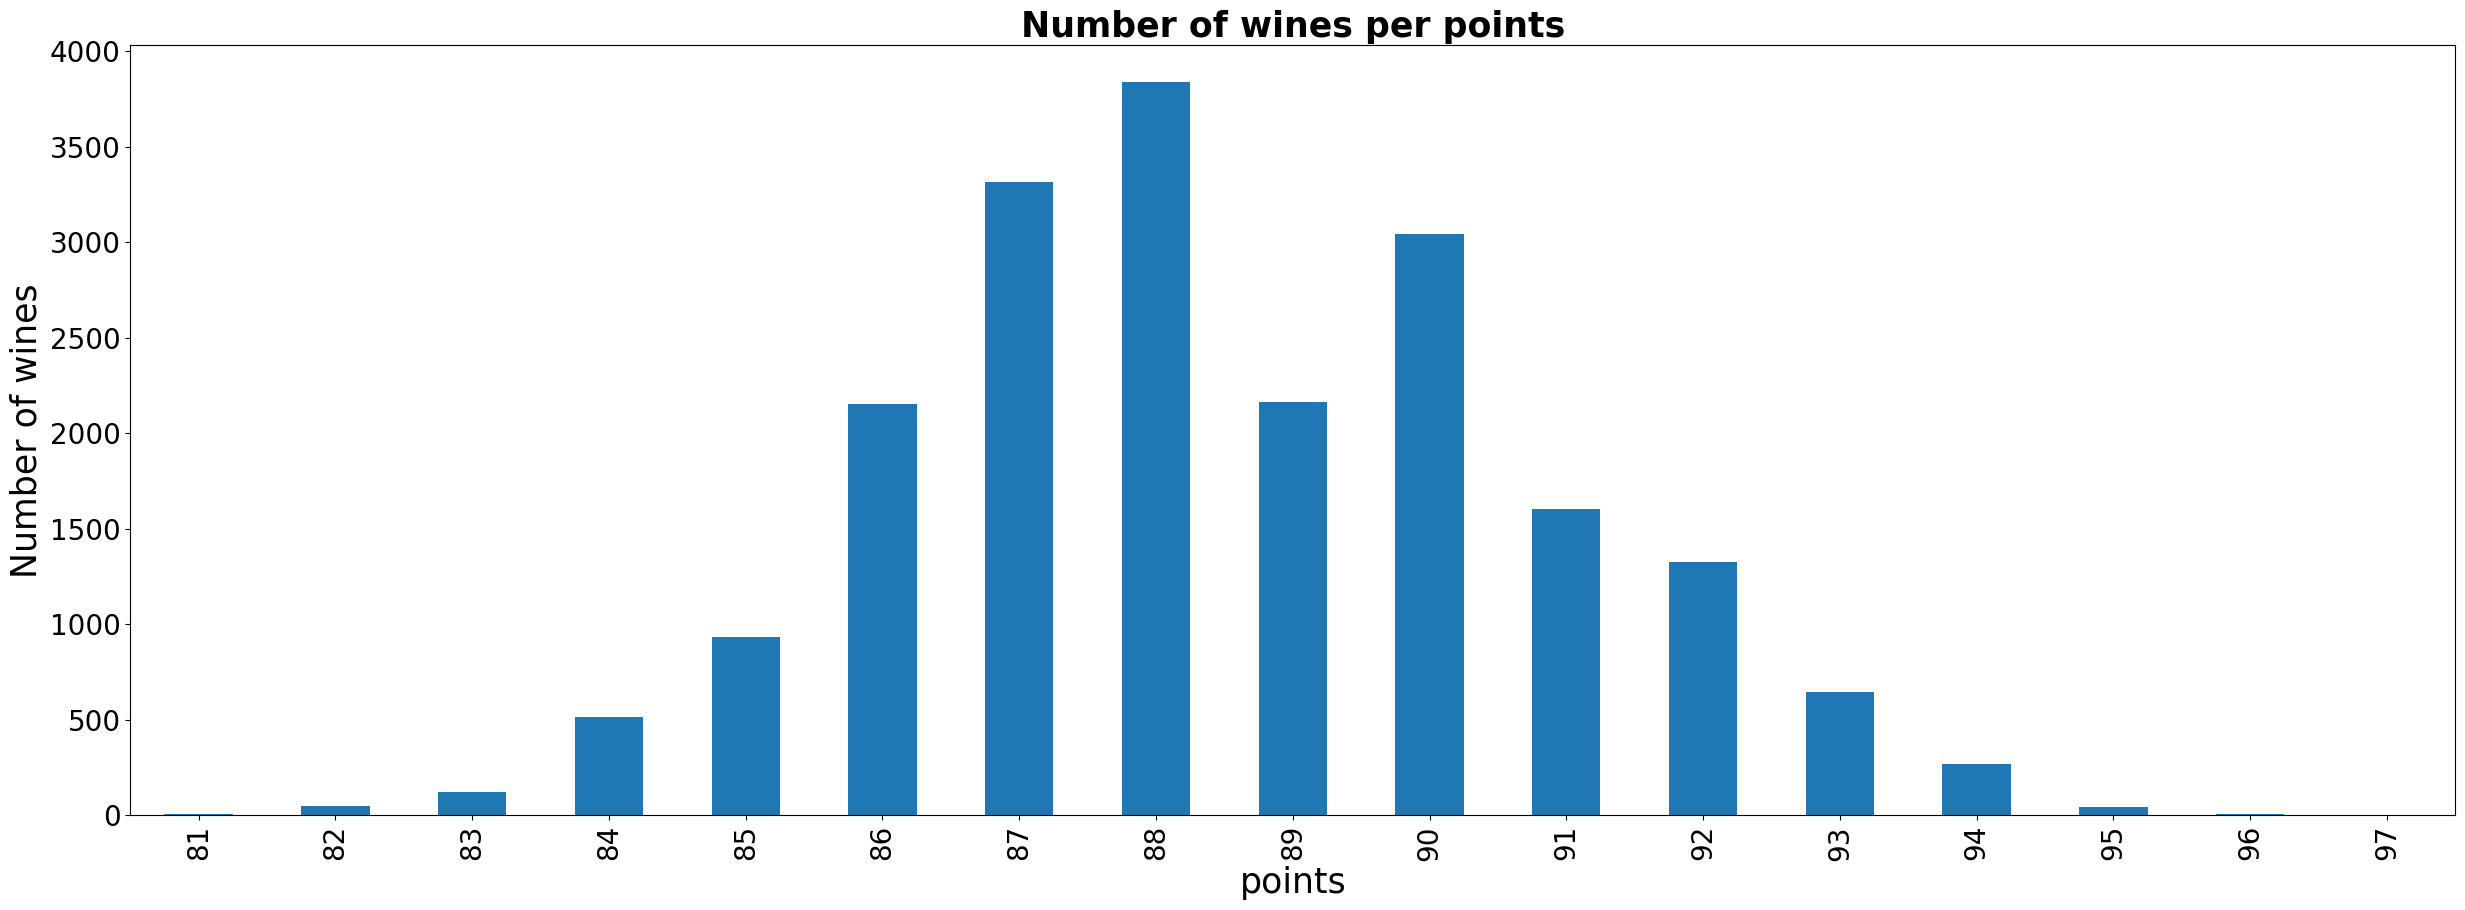

In [6]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of wines per points', fontweight="bold", size=25) # Title
ax.set_ylabel('Number of wines', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
dp.groupby(['points']).count()['description'].plot(ax=ax, kind='bar')
plt.show()

**Conclusion:** 

A lot of wines from 83 to 93 points. Which also matches the market (not a lot of really good wines). If we wanted a better model, we could try to scrape more wine reviews based on points to flatten this.

## Taking a look at Description length vs points

In [7]:
dp = dp.assign(description_length = dp['description'].apply(len))
dp.info()
dp.head()

<class 'pandas.core.frame.DataFrame'>
Index: 20026 entries, 9 to 129913
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   description         20026 non-null  object
 1   points              20026 non-null  int64 
 2   description_length  20026 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 625.8+ KB


,description,points,description_length
9,This has great depth of flavor with its fresh ...,87,160
10,"Soft, supple plum envelopes an oaky structure ...",87,243
11,"This is a dry wine, very spicy, with a tight, ...",87,179
12,"Slightly reduced, this wine offers a chalky, t...",87,171
13,This is dominated by oak and oak-driven aromas...,87,234


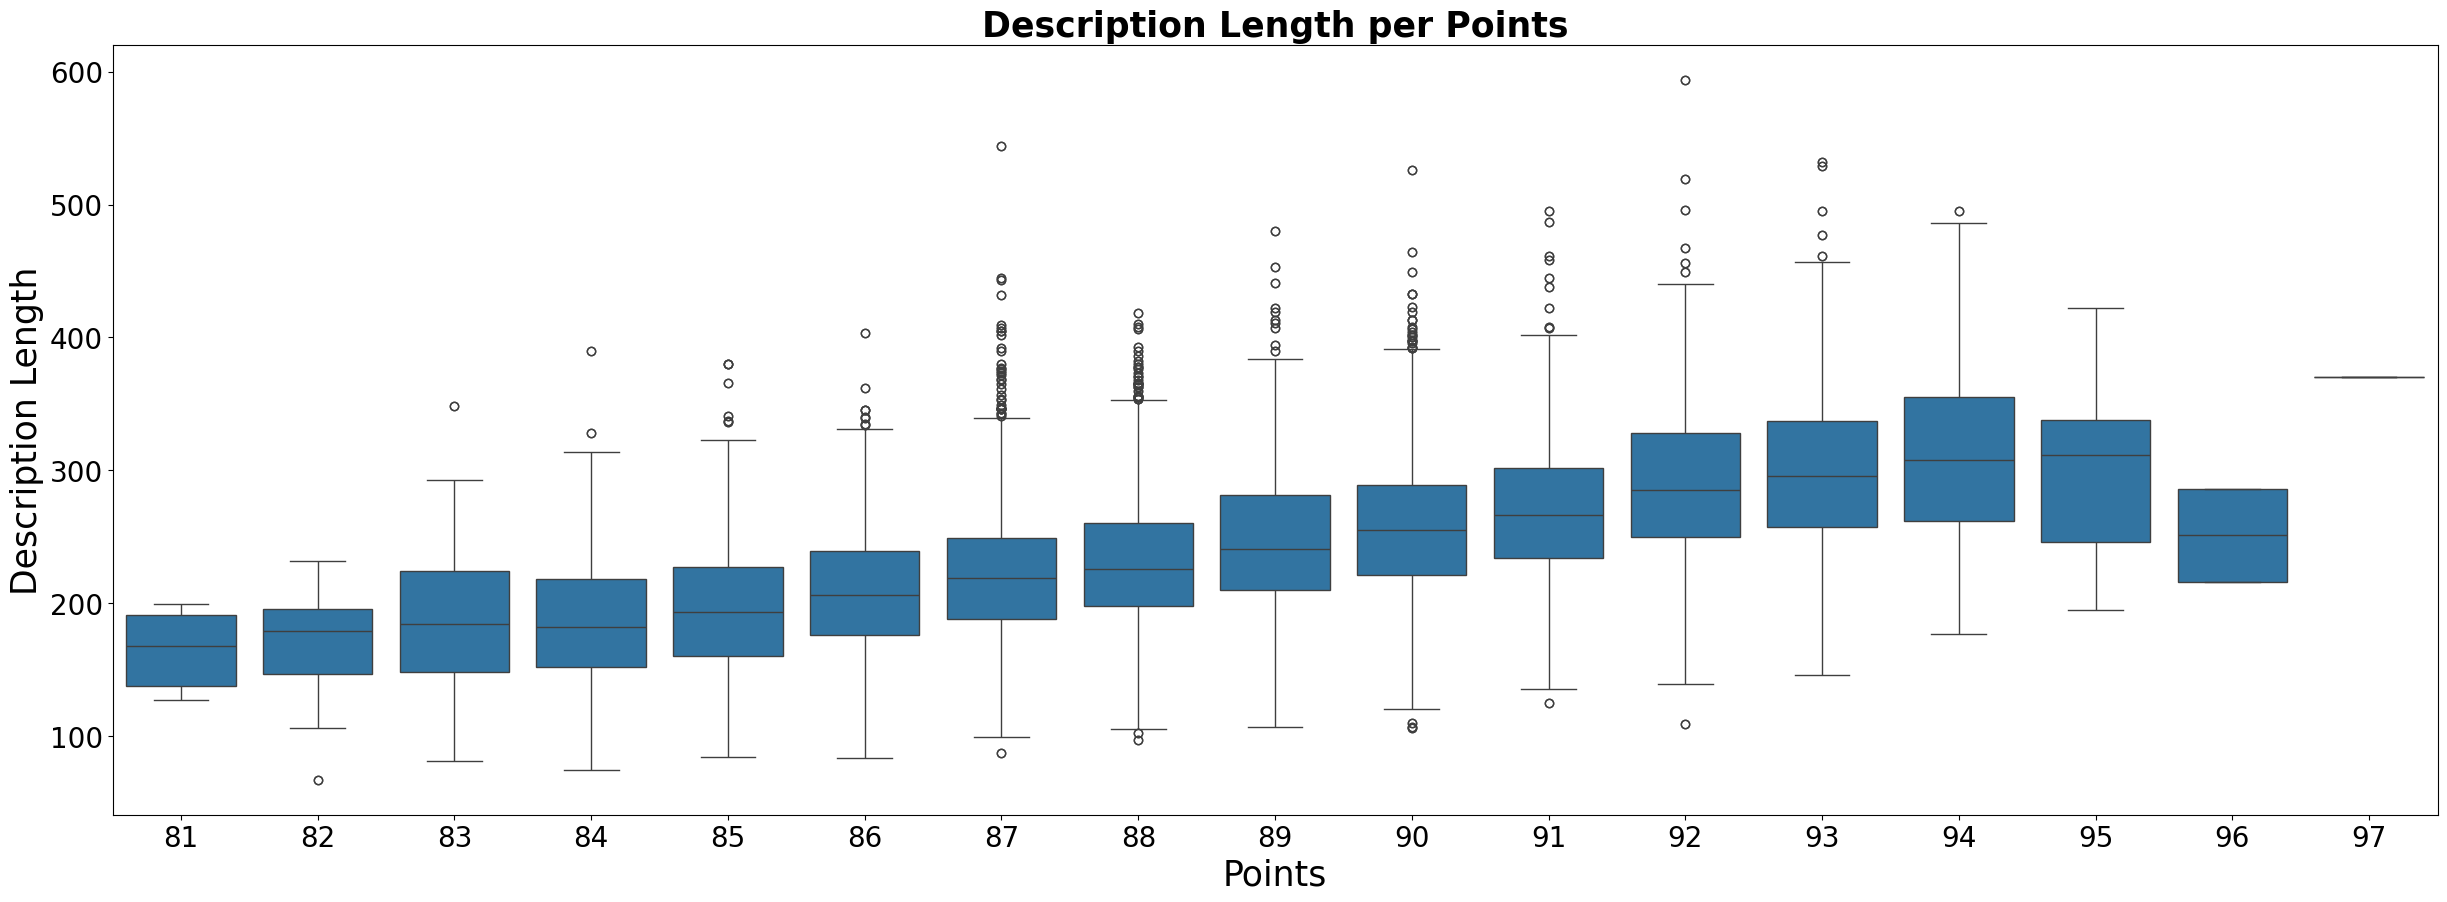

In [8]:
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='points', y='description_length', data=dp)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Points', fontweight="bold", size=25) # Title
ax.set_ylabel('Description Length', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
plt.show()

## Simplifying the model

Having too many different possibility for "points" would burden our model.
A 90 points wine is not that different from a 91 points wine, the description is probably not that different also. We can this throughout the descriptions' length as well.

Let's try to simplify the model with 5 different values:

1 -> Points 80 to 84 (Under Average wines)

2 -> Points 84 to 88 (Average wines)

3 -> Points 88 to 92 (Good wines)

4 -> Points 92 to 96 (Very Good wines)

5 -> Points 96 to 100 (Excellent wines)

In [9]:
#Transform method taking points as param
def transform_points_simplified(points):
    if points < 83:
        return 'acceptable'
    elif points >= 83 and points < 87:
        return 'good' 
    elif points >= 87 and points < 90:
        return 'very good' 
    elif points >= 90 and points < 94:
        return 'excellent'
    elif points >= 94 and points < 98:
        return 'superb'
    else:
        return 'classic'

#Applying transform method and assigning result to new column "points_simplified"
dp = dp.assign(points_simplified = dp['points'].apply(transform_points_simplified))
dp.head()

,description,points,description_length,points_simplified
9,This has great depth of flavor with its fresh ...,87,160,very good
10,"Soft, supple plum envelopes an oaky structure ...",87,243,very good
11,"This is a dry wine, very spicy, with a tight, ...",87,179,very good
12,"Slightly reduced, this wine offers a chalky, t...",87,171,very good
13,This is dominated by oak and oak-driven aromas...,87,234,very good


How many wines per simplified points?
That's the new distribution of our data model

<Axes: title={'center': 'Number of wines per points'}, xlabel='points_simplified', ylabel='Number of wines'>

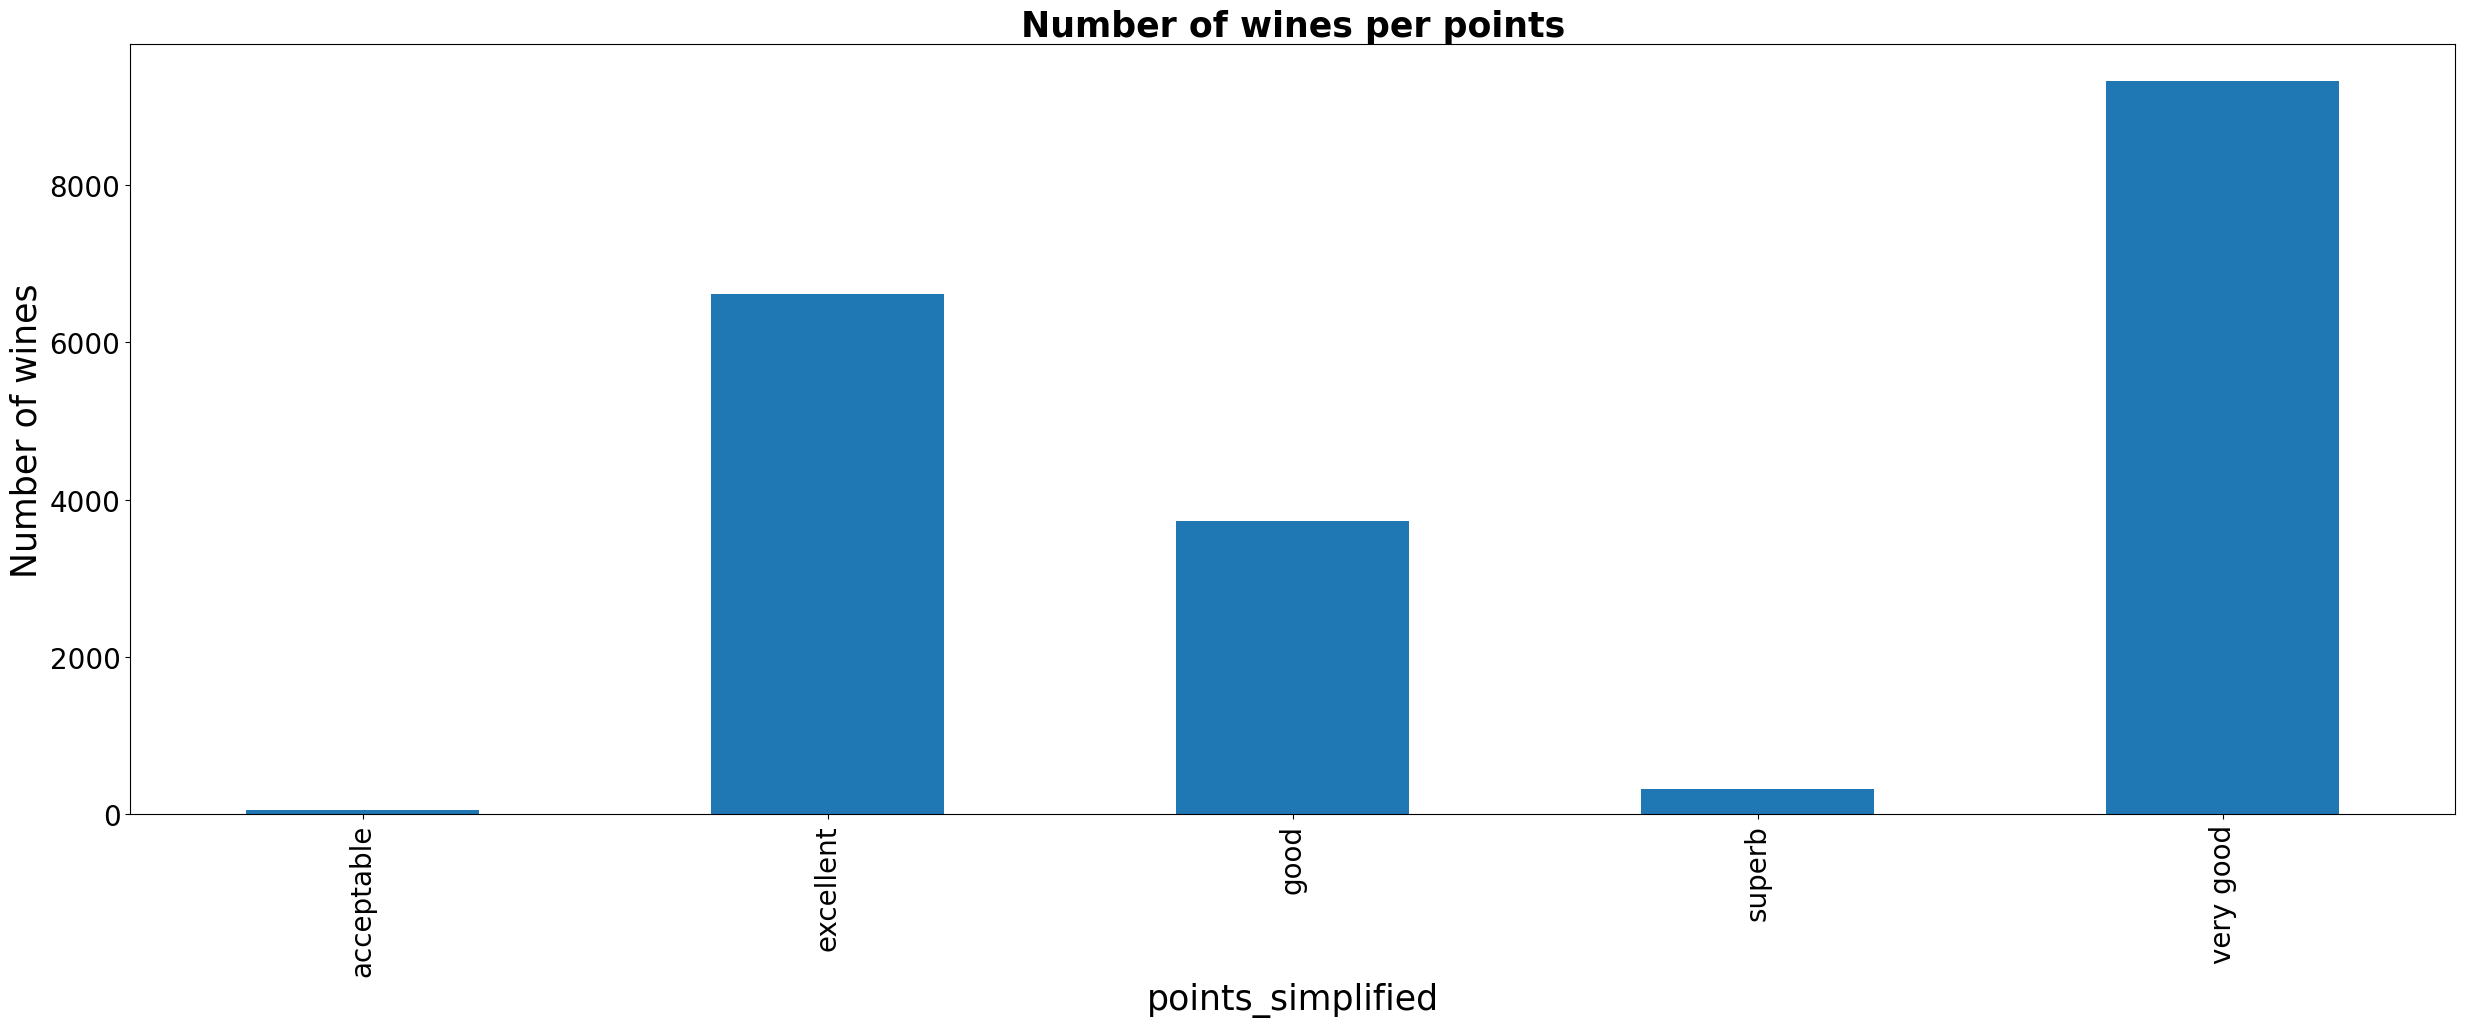

In [10]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of wines per points', fontweight="bold", size=25) # Title
ax.set_ylabel('Number of wines', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
dp.groupby(['points_simplified']).count()['description'].plot(ax=ax, kind='bar')

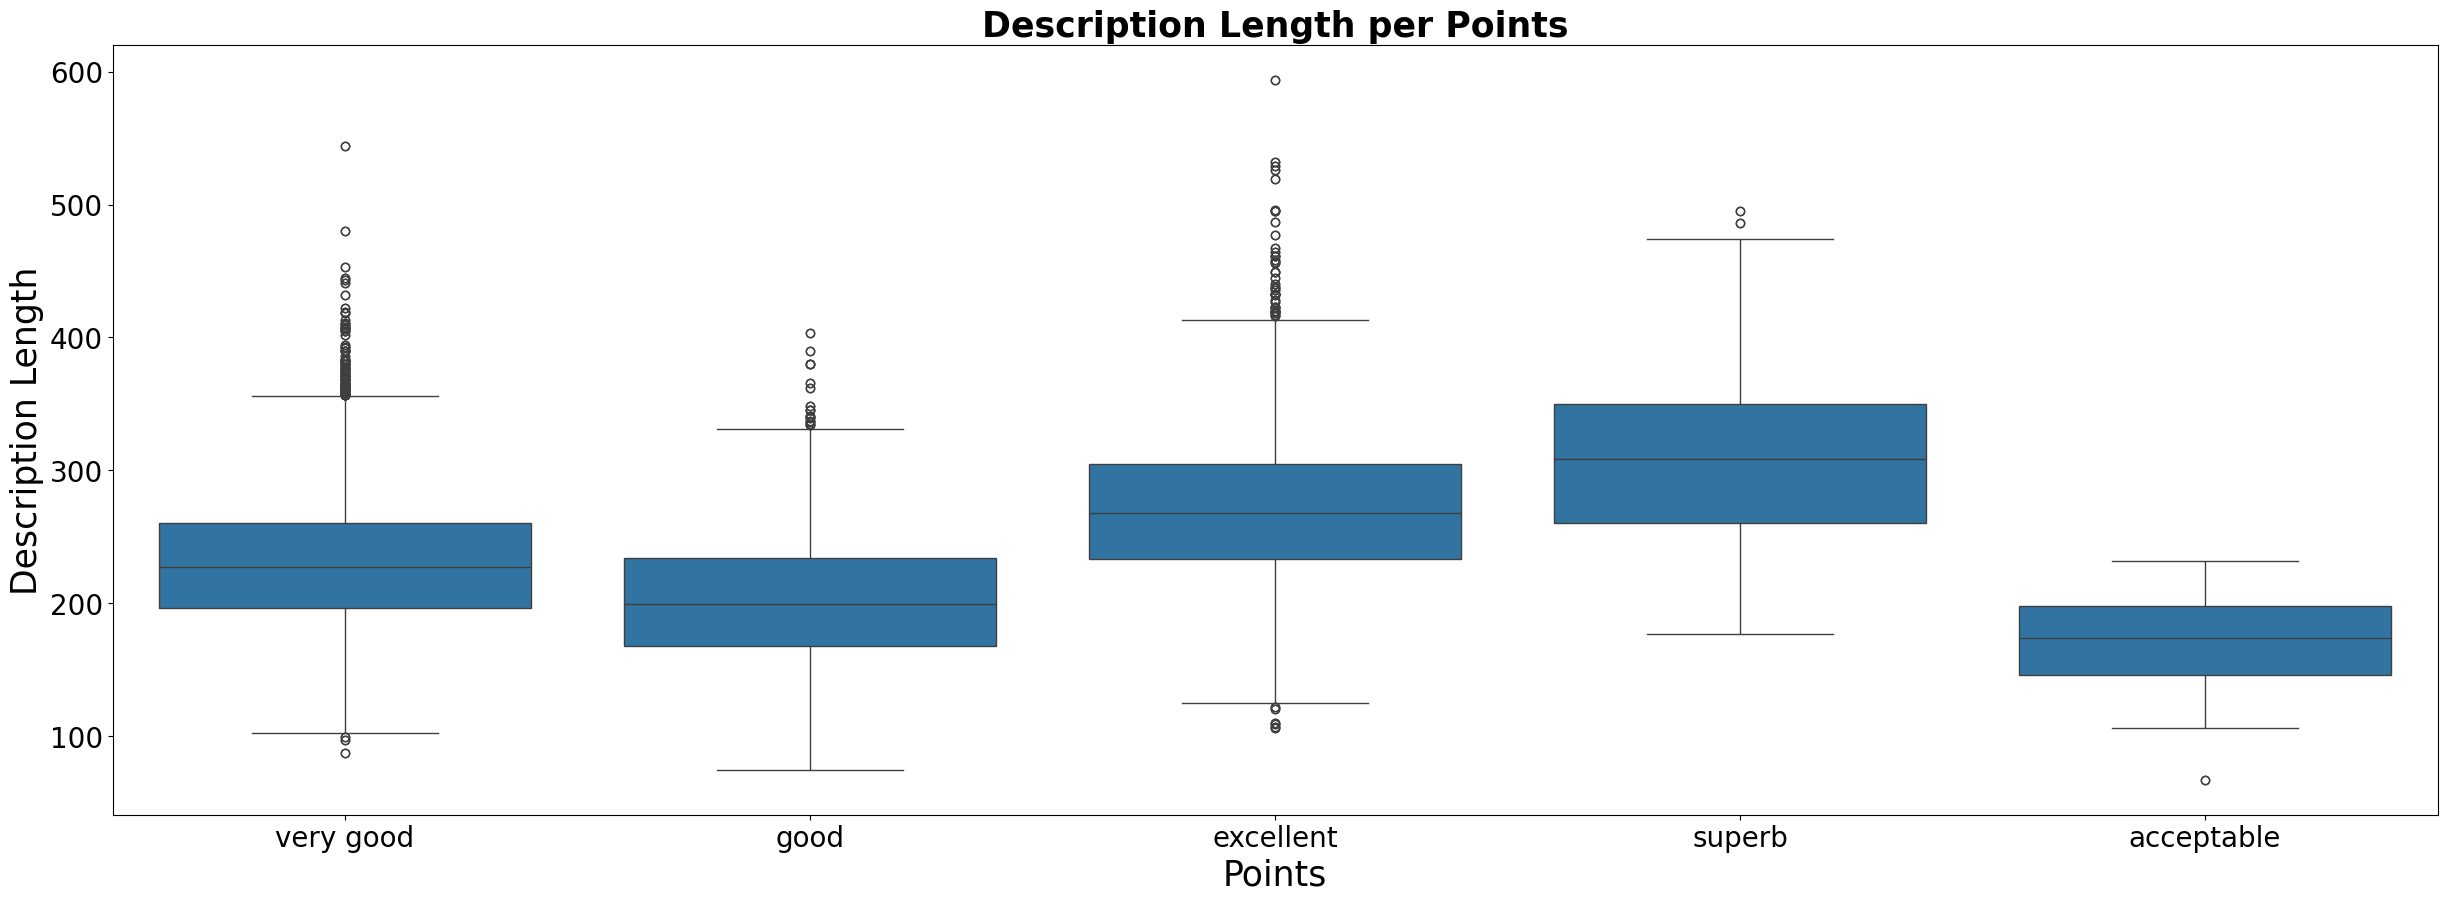

In [11]:
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='points_simplified', y='description_length', data=dp)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Points', fontweight="bold", size=25) # Title
ax.set_ylabel('Description Length', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
plt.show()

## Description Vectorization

Let's see what CountVectorizer output on this collection

In [12]:
X = dp['description']
y = dp['points_simplified']

vectorizer = CountVectorizer()
vectorizer.fit(X)
#print(vectorizer.vocabulary_)

CountVectorizer()

Let's vectorize X based on the trained data.

In [13]:
X = vectorizer.transform(X)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (20026, 10992)
Amount of Non-Zero occurrences:  683286
Density: 0.3104070603412071


## Training data and test data

90% of the dataset will be used for training. 10% of the dataset will be used for testing.

In [14]:
# Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Testing the model
predictions = rfc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

  acceptable       1.00      1.00      1.00         6
   excellent       0.99      0.95      0.97       670
        good       1.00      0.93      0.96       380
      superb       1.00      0.92      0.96        48
   very good       0.93      0.99      0.96       899

    accuracy                           0.96      2003
   macro avg       0.98      0.96      0.97      2003
weighted avg       0.97      0.96      0.96      2003



## Result With CountVectorizer: 97% precision, recall and f1
It's super good!

Multiple hypothesis to improve this model: 
1. We could try a different vectorizer (TfidfVectorizer for example)
2. We could try cleaning the dataset using stopwords
3. We could add other metrics like price, description length etc... to our model

## Trying TfidfVectorizer

TfidfVectorizer has some advantages over the simpler CountVectorizer.

CountVectorizer just counts the word frequencies. That's all.

With TfidfVectorizer the value increases proportionally to count, but is offset by the frequency of the word in the total corpus. This is called the IDF (inverse document frequency part).
This allow the Vectorizer to adjust with frequent words like "the", "a" etc...

In [15]:
X = dp['description']
y = dp['points_simplified']

# Vectorizing model
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [16]:
# Training model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Testing model
predictions = rfc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

  acceptable       1.00      1.00      1.00         6
   excellent       0.98      0.96      0.97       670
        good       1.00      0.93      0.96       380
      superb       1.00      0.92      0.96        48
   very good       0.94      0.98      0.96       899

    accuracy                           0.96      2003
   macro avg       0.98      0.96      0.97      2003
weighted avg       0.97      0.96      0.96      2003



## Results with TfidfVectorizer: 97% precision, recall and f1
Slightly better precisions for some buckets. TfidfVectorizer might also be more performant with larger volumes of data, knowing how the algorithm works.

# Conclusion
The CountVectorizer/TfidfVectorizer and RandomForestClassifier looks like a great combinaison to analyze wine ratings on our dataset!